# MovieMind - Geographic Visualization

This notebook creates geo-visualizations analyzing sentiment and movie data by production country.

## Contents:
1. Data Loading
2. Country-Level Aggregation
3. Choropleth Maps (Sentiment by Country)
4. Statistical Analysis by Region
5. Interactive Visualizations

In [1]:
# Imports
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

from src.utils.db_manager import DatabaseManager

# Settings
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline
pd.set_option('display.max_columns', None)

## 1. Data Loading

In [2]:
# Load movie and review data
with DatabaseManager() as db:
    query = """
    SELECT 
        m.movie_id,
        m.title,
        m.production_countries,
        m.vote_average,
        m.vote_count,
        m.genres,
        r.sentiment,
        r.sentiment_score
    FROM movies m
    LEFT JOIN reviews r ON m.movie_id = r.movie_id
    WHERE m.production_countries IS NOT NULL
    """
    df = pd.DataFrame(db.execute_query(query))

print(f"Loaded {len(df)} records")
print(f"Unique movies: {df['movie_id'].nunique()}")
df.head()

INFO:src.utils.db_manager:Database connection established


INFO:src.utils.db_manager:Database connection closed


Loaded 685 records
Unique movies: 470


,movie_id,title,production_countries,vote_average,vote_count,genres,sentiment,sentiment_score
0,1084242,Zootopia 2,[US],7.6,903,"[Animation, Comedy, Adventure, Family, Mystery]",None,None
1,1084242,Zootopia 2,[US],7.6,903,"[Animation, Comedy, Adventure, Family, Mystery]",None,None
2,1084242,Zootopia 2,[US],7.6,903,"[Animation, Comedy, Adventure, Family, Mystery]",None,None
3,1131759,Omniscient Reader: The Prophecy,[KR],6.7,38,"[Action, Adventure, Fantasy]",None,None
4,324857,Spider-Man: Into the Spider-Verse,[US],8.4,16707,"[Animation, Action, Adventure, Science Fiction]",None,None


## 2. Country-Level Aggregation

In [3]:
# Explode production_countries (movies can have multiple countries)
df_exploded = df.copy()
df_exploded['country'] = df_exploded['production_countries']

# Flatten country lists
rows = []
for idx, row in df.iterrows():
    if isinstance(row['production_countries'], list):
        for country in row['production_countries']:
            new_row = row.copy()
            new_row['country'] = country
            rows.append(new_row)

df_countries = pd.DataFrame(rows)
print(f"Expanded to {len(df_countries)} country-movie-review combinations")
print(f"Unique countries: {df_countries['country'].nunique()}")

Expanded to 885 country-movie-review combinations
Unique countries: 45


In [4]:
# Aggregate by country
country_stats = df_countries.groupby('country').agg({
    'movie_id': 'nunique',
    'vote_average': 'mean',
    'sentiment_score': 'mean',
    'sentiment': lambda x: (x == 'positive').sum() / len(x) * 100 if len(x) > 0 else 0
}).reset_index()

country_stats.columns = ['country', 'movie_count', 'avg_rating', 'avg_sentiment_score', 'positive_percentage']

# Filter countries with at least 5 movies
country_stats = country_stats[country_stats['movie_count'] >= 5].sort_values('movie_count', ascending=False)

print(f"\nCountries with at least 5 movies: {len(country_stats)}")
print("\nTop 15 countries by movie count:")
display(country_stats.head(15))


Countries with at least 5 movies: 17

Top 15 countries by movie count:


,country,movie_count,avg_rating,avg_sentiment_score,positive_percentage
42,US,282,7.654013,NaN,0.0
14,GB,56,7.395652,NaN,0.0
21,JP,49,7.912308,NaN,0.0
13,FR,37,7.677500,NaN,0.0
20,IT,22,8.057692,NaN,0.0
22,KR,21,7.256000,NaN,0.0
7,DE,18,7.455556,NaN,0.0
5,CN,16,7.466667,NaN,0.0
4,CA,14,7.348387,NaN,0.0
11,ES,12,6.941667,NaN,0.0


In [5]:
# Map country codes to full names (ISO 3166-1 alpha-2)
country_name_map = {
    'US': 'United States', 'GB': 'United Kingdom', 'FR': 'France', 'DE': 'Germany',
    'IT': 'Italy', 'ES': 'Spain', 'JP': 'Japan', 'KR': 'South Korea', 'CN': 'China',
    'IN': 'India', 'CA': 'Canada', 'AU': 'Australia', 'BR': 'Brazil', 'MX': 'Mexico',
    'RU': 'Russia', 'SE': 'Sweden', 'NO': 'Norway', 'DK': 'Denmark', 'FI': 'Finland',
    'NL': 'Netherlands', 'BE': 'Belgium', 'AT': 'Austria', 'CH': 'Switzerland',
    'NZ': 'New Zealand', 'AR': 'Argentina', 'IE': 'Ireland', 'PL': 'Poland',
    'CZ': 'Czech Republic', 'HU': 'Hungary', 'GR': 'Greece', 'PT': 'Portugal',
    'TR': 'Turkey', 'IL': 'Israel', 'ZA': 'South Africa', 'TH': 'Thailand',
    'ID': 'Indonesia', 'MY': 'Malaysia', 'SG': 'Singapore', 'PH': 'Philippines',
    'HK': 'Hong Kong', 'TW': 'Taiwan'
}

country_stats['country_name'] = country_stats['country'].map(country_name_map)
country_stats['country_name'] = country_stats['country_name'].fillna(country_stats['country'])

# For choropleth, we need ISO3 codes
# Simple mapping (extend as needed)
iso2_to_iso3 = {
    'US': 'USA', 'GB': 'GBR', 'FR': 'FRA', 'DE': 'DEU', 'IT': 'ITA', 'ES': 'ESP',
    'JP': 'JPN', 'KR': 'KOR', 'CN': 'CHN', 'IN': 'IND', 'CA': 'CAN', 'AU': 'AUS',
    'BR': 'BRA', 'MX': 'MEX', 'RU': 'RUS', 'SE': 'SWE', 'NO': 'NOR', 'DK': 'DNK',
    'FI': 'FIN', 'NL': 'NLD', 'BE': 'BEL', 'AT': 'AUT', 'CH': 'CHE', 'NZ': 'NZL',
    'AR': 'ARG', 'IE': 'IRL', 'PL': 'POL', 'CZ': 'CZE', 'HU': 'HUN', 'GR': 'GRC',
    'PT': 'PRT', 'TR': 'TUR', 'IL': 'ISR', 'ZA': 'ZAF', 'TH': 'THA', 'ID': 'IDN',
    'MY': 'MYS', 'SG': 'SGP', 'PH': 'PHL', 'HK': 'HKG', 'TW': 'TWN'
}

country_stats['iso3'] = country_stats['country'].map(iso2_to_iso3)
country_stats['iso3'] = country_stats['iso3'].fillna(country_stats['country'])

## 3. Choropleth Maps

In [6]:
# Choropleth: Average Sentiment Score by Country
fig1 = px.choropleth(
    country_stats,
    locations='iso3',
    color='avg_sentiment_score',
    hover_name='country_name',
    hover_data={'movie_count': True, 'avg_rating': ':.2f', 'positive_percentage': ':.1f', 'iso3': False},
    color_continuous_scale='RdYlGn',
    title='Average Sentiment Score by Production Country',
    labels={'avg_sentiment_score': 'Avg Sentiment Score'}
)

fig1.update_layout(
    geo=dict(showframe=False, showcoastlines=True, projection_type='equirectangular'),
    height=600
)

fig1.show()

In [7]:
# Choropleth: Average Rating by Country
fig2 = px.choropleth(
    country_stats,
    locations='iso3',
    color='avg_rating',
    hover_name='country_name',
    hover_data={'movie_count': True, 'avg_sentiment_score': ':.2f', 'positive_percentage': ':.1f', 'iso3': False},
    color_continuous_scale='Viridis',
    title='Average Movie Rating by Production Country',
    labels={'avg_rating': 'Avg Rating'}
)

fig2.update_layout(
    geo=dict(showframe=False, showcoastlines=True, projection_type='equirectangular'),
    height=600
)

fig2.show()

In [8]:
# Choropleth: Number of Movies by Country (log scale for better visualization)
country_stats['log_movie_count'] = np.log10(country_stats['movie_count'] + 1)

fig3 = px.choropleth(
    country_stats,
    locations='iso3',
    color='log_movie_count',
    hover_name='country_name',
    hover_data={'movie_count': True, 'avg_rating': ':.2f', 'avg_sentiment_score': ':.2f', 
                'log_movie_count': False, 'iso3': False},
    color_continuous_scale='Blues',
    title='Number of Movies by Production Country (Log Scale)',
    labels={'log_movie_count': 'Log(Movie Count)'}
)

fig3.update_layout(
    geo=dict(showframe=False, showcoastlines=True, projection_type='equirectangular'),
    height=600
)

fig3.show()

## 4. Statistical Analysis by Country

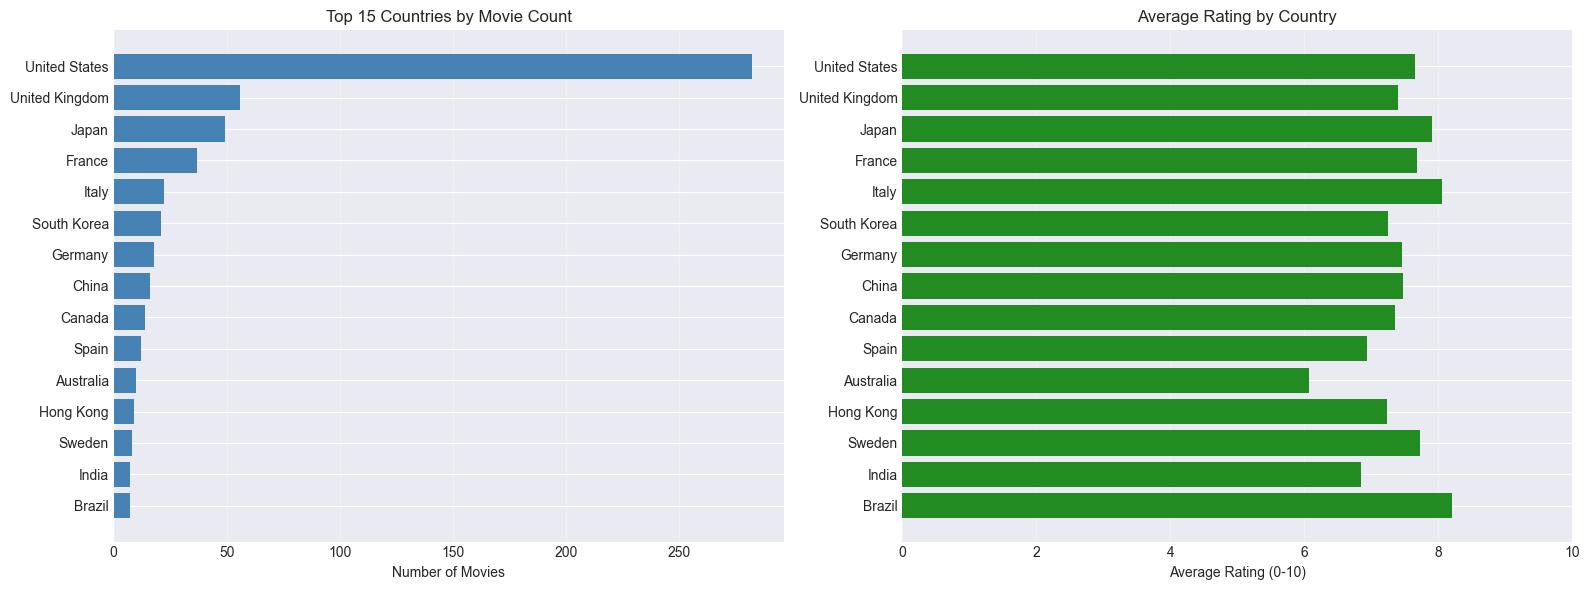

In [9]:
# Top countries comparison
top_15_countries = country_stats.head(15)

# Check if we have sentiment data
has_sentiment = top_15_countries['avg_sentiment_score'].notna().any()

if has_sentiment:
    # 4-panel layout if we have sentiment data
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Movie count
    axes[0, 0].barh(top_15_countries['country_name'], top_15_countries['movie_count'])
    axes[0, 0].set_xlabel('Number of Movies')
    axes[0, 0].set_title('Top 15 Countries by Movie Count')
    axes[0, 0].invert_yaxis()

    # Average rating
    axes[0, 1].barh(top_15_countries['country_name'], top_15_countries['avg_rating'], color='green')
    axes[0, 1].set_xlabel('Average Rating')
    axes[0, 1].set_title('Average Rating by Country')
    axes[0, 1].invert_yaxis()

    # Sentiment score
    axes[1, 0].barh(top_15_countries['country_name'], top_15_countries['avg_sentiment_score'], color='orange')
    axes[1, 0].set_xlabel('Average Sentiment Score')
    axes[1, 0].set_title('Average Sentiment Score by Country')
    axes[1, 0].invert_yaxis()

    # Positive percentage
    axes[1, 1].barh(top_15_countries['country_name'], top_15_countries['positive_percentage'], color='purple')
    axes[1, 1].set_xlabel('Positive Reviews (%)')
    axes[1, 1].set_title('Positive Review Percentage by Country')
    axes[1, 1].invert_yaxis()
else:
    # 2-panel layout if no sentiment data
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Movie count
    axes[0].barh(top_15_countries['country_name'], top_15_countries['movie_count'], color='steelblue')
    axes[0].set_xlabel('Number of Movies')
    axes[0].set_title('Top 15 Countries by Movie Count')
    axes[0].invert_yaxis()
    axes[0].grid(axis='x', alpha=0.3)

    # Average rating
    axes[1].barh(top_15_countries['country_name'], top_15_countries['avg_rating'], color='forestgreen')
    axes[1].set_xlabel('Average Rating (0-10)')
    axes[1].set_title('Average Rating by Country')
    axes[1].invert_yaxis()
    axes[1].grid(axis='x', alpha=0.3)
    axes[1].set_xlim(0, 10)

plt.tight_layout()
plt.show()

In [10]:
# Correlation: Movie count vs Average rating
from scipy import stats

# Filter countries with enough data
countries_for_corr = country_stats[country_stats['movie_count'] >= 10]

# Correlation 1: Movie count vs Average rating
corr_count_rating, p_val_1 = stats.pearsonr(
    countries_for_corr['movie_count'],
    countries_for_corr['avg_rating']
)

print("\n" + "="*80)
print("CORRELATION ANALYSIS")
print("="*80)
print(f"\nMovie Count vs Average Rating:")
print(f"  Correlation: {corr_count_rating:.3f}")
print(f"  p-value: {p_val_1:.4f}")
print(f"  Significant: {'Yes' if p_val_1 < 0.05 else 'No'}")

# Correlation 2: Movie count vs Sentiment (only if we have valid sentiment data)
valid_sentiment_for_corr = countries_for_corr.dropna(subset=['avg_sentiment_score'])
if len(valid_sentiment_for_corr) >= 2:
    corr_count_sentiment, p_val_2 = stats.pearsonr(
        valid_sentiment_for_corr['movie_count'],
        valid_sentiment_for_corr['avg_sentiment_score']
    )
    print(f"\nMovie Count vs Sentiment Score:")
    print(f"  Correlation: {corr_count_sentiment:.3f}")
    print(f"  p-value: {p_val_2:.4f}")
    print(f"  Significant: {'Yes' if p_val_2 < 0.05 else 'No'}")
else:
    print(f"\nMovie Count vs Sentiment Score:")
    print(f"  Not enough sentiment data for correlation analysis")

print("="*80)


CORRELATION ANALYSIS

Movie Count vs Average Rating:
  Correlation: 0.259
  p-value: 0.4424
  Significant: No

Movie Count vs Sentiment Score:
  Not enough sentiment data for correlation analysis


## 5. Interactive Scatter Plot

In [11]:
# Interactive scatter: Rating vs Sentiment (only if sentiment data available)
has_sentiment = country_stats['avg_sentiment_score'].notna().any()

if has_sentiment:
    fig_scatter = px.scatter(
        country_stats,
        x='avg_rating',
        y='avg_sentiment_score',
        size='movie_count',
        color='positive_percentage',
        hover_name='country_name',
        hover_data={'movie_count': True, 'avg_rating': ':.2f', 'avg_sentiment_score': ':.2f'},
        title='Movie Rating vs Sentiment Score by Country',
        labels={
            'avg_rating': 'Average Rating',
            'avg_sentiment_score': 'Average Sentiment Score',
            'positive_percentage': 'Positive %'
        },
        color_continuous_scale='RdYlGn',
        size_max=60
    )

    fig_scatter.update_layout(height=600)
    fig_scatter.show()
else:
    print("Note: Scatter plot skipped - no sentiment data available in the dataset.")
    print("To enable this visualization, ensure reviews have sentiment scores in the database.")

Note: Scatter plot skipped - no sentiment data available in the dataset.
To enable this visualization, ensure reviews have sentiment scores in the database.


## Summary

In [12]:
print("\n" + "="*80)
print("GEO-VISUALIZATION SUMMARY")
print("="*80)
print(f"\nTotal countries analyzed: {len(country_stats)}")
print(f"Top producing country: {country_stats.iloc[0]['country_name']} ({country_stats.iloc[0]['movie_count']} movies)")

# Highest rated country
highest_rated = country_stats.loc[country_stats['avg_rating'].idxmax()]
print(f"\nHighest rated country: {highest_rated['country_name']} (avg rating: {highest_rated['avg_rating']:.2f})")

# Most positive sentiment (check if we have valid sentiment data)
valid_sentiment = country_stats.dropna(subset=['avg_sentiment_score'])
if len(valid_sentiment) > 0:
    most_positive = valid_sentiment.loc[valid_sentiment['avg_sentiment_score'].idxmax()]
    print(f"Most positive sentiment: {most_positive['country_name']} (sentiment score: {most_positive['avg_sentiment_score']:.2f})")
else:
    print("Most positive sentiment: No sentiment data available")

print("\n" + "="*80)


GEO-VISUALIZATION SUMMARY

Total countries analyzed: 17
Top producing country: United States (282 movies)

Highest rated country: Brazil (avg rating: 8.20)
Most positive sentiment: No sentiment data available

